# Week 12 - Model  Selection and Building

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import missingno as msno
from operator import itemgetter
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (GradientBoostingRegressor, GradientBoostingClassifier)
pd.set_option('display.max_columns', 500)
#import xgboost

%matplotlib inline
sns.set()
plt.rc('xtick', labelsize=10)     
plt.rc('ytick', labelsize=10)


In [53]:
from pycaret.classification import *

## Dataset

In [54]:
path = "/Users/vicentesolorzano/Desktop/DATA_GLACIER/FINAL/data/bank-additional-full.csv"

bank_df = pd.read_csv(path,sep=";")
bank_df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [55]:
numerical_cols=['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']
 
categorical_cols=['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [56]:
bank_df[categorical_cols]

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent
...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,no,yes,no,cellular,nov,fri,nonexistent
41184,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,nonexistent
41185,retired,married,university.degree,no,yes,no,cellular,nov,fri,nonexistent
41186,technician,married,professional.course,no,no,no,cellular,nov,fri,nonexistent


In [57]:
print("Number of rows: ",bank_df.shape[0]," - ","Number of columns: ",bank_df.shape[1])

Number of rows:  41188  -  Number of columns:  21


#### Target

We want to see the distribution of the binary target, to realise if it is unbalanced or not.

In [58]:
print('"y" distribution in % : \n', (bank_df.groupby("y")["y"].count())/bank_df.y.count()*100)

print('"y" distribution in instances: \n', bank_df.groupby("y")["y"].count())

"y" distribution in % : 
 y
no     88.734583
yes    11.265417
Name: y, dtype: float64
"y" distribution in instances: 
 y
no     36548
yes     4640
Name: y, dtype: int64


Target is umbalanced. We will need to use SMOTE technique .

## 1) Outliers detection

#### Boxplot view

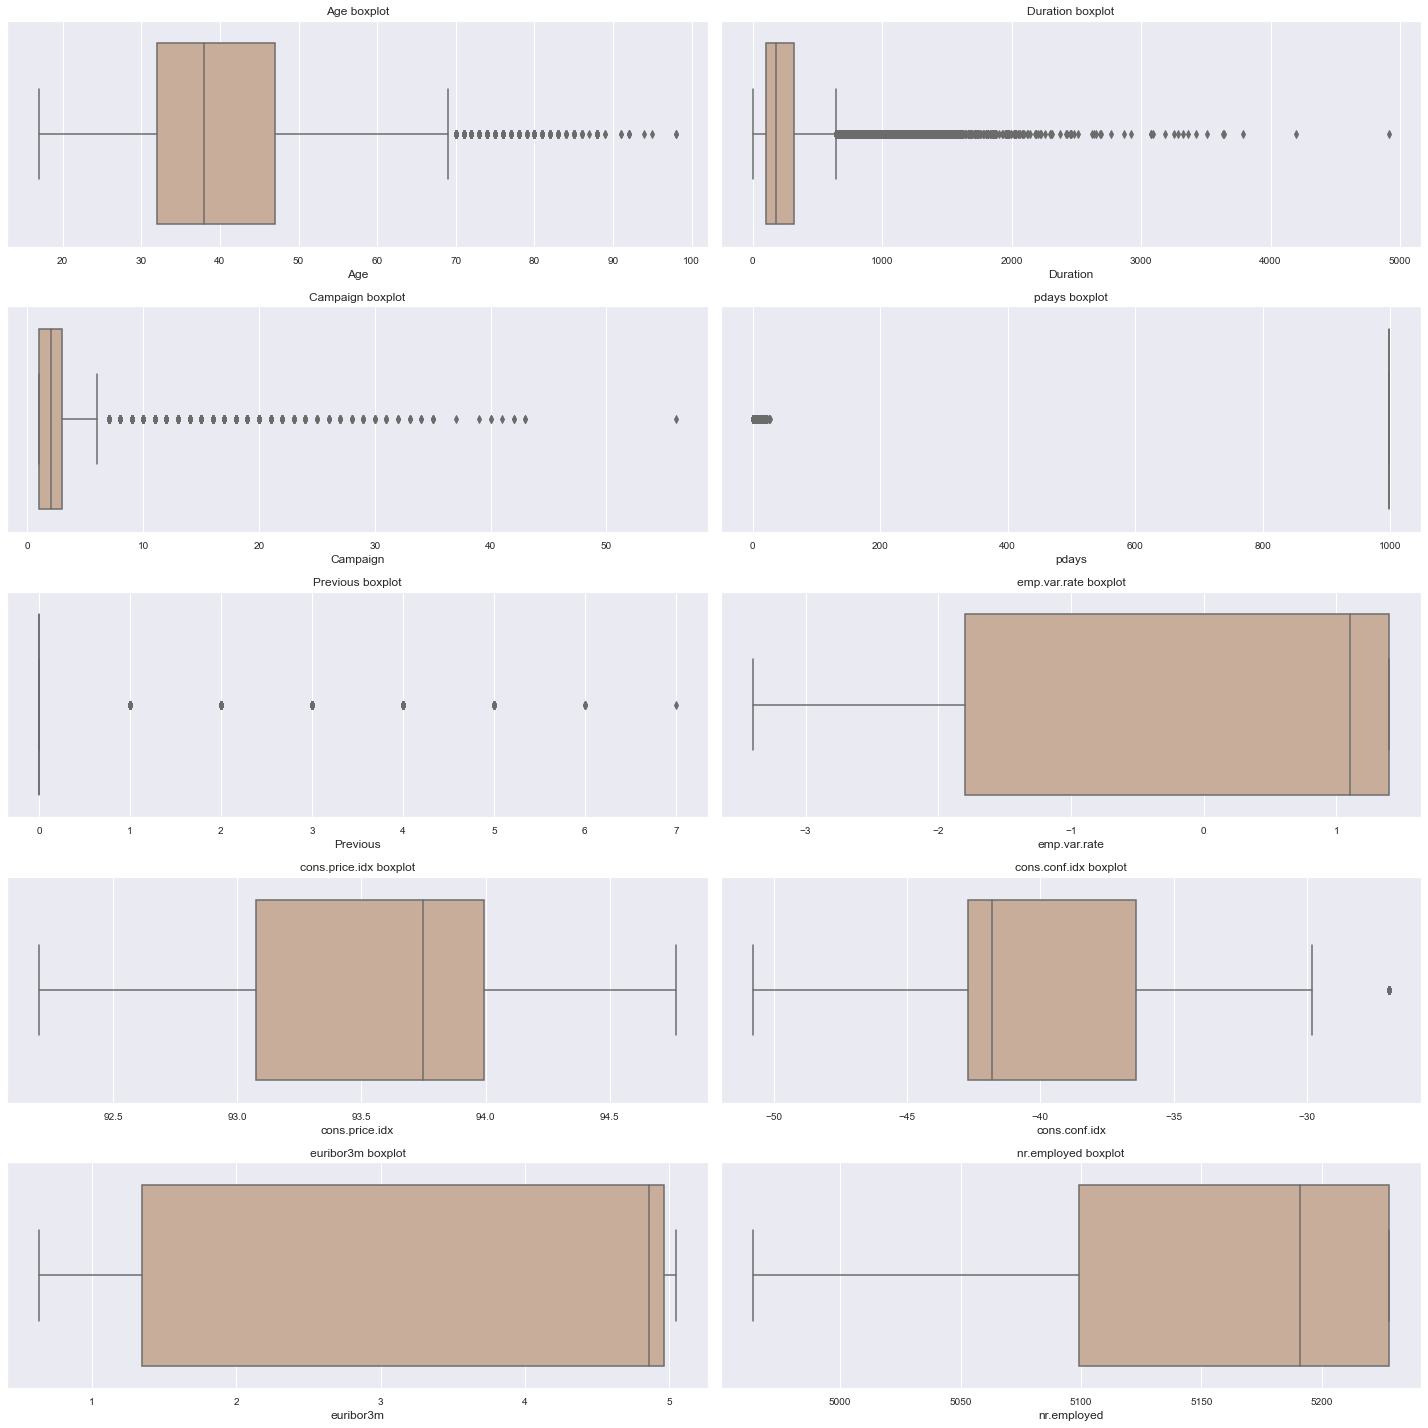

In [44]:
plt.figure(figsize = (20,20))
plt.subplot(5, 2, 1)
sns.boxplot(data = bank_df, x= 'age', palette = 'pink')
plt.title('Age boxplot')
plt.xlabel('Age')

plt.subplot(5, 2, 2)
sns.boxplot(data = bank_df, x= 'duration', palette = 'pink')
plt.title('Duration boxplot')
plt.xlabel('Duration')

plt.subplot(5, 2, 3)
sns.boxplot(data = bank_df, x= 'campaign', palette = 'pink')
plt.title('Campaign boxplot')
plt.xlabel('Campaign')

plt.subplot(5, 2, 4)
sns.boxplot(data = bank_df, x= 'pdays', palette = 'pink')
plt.title('pdays boxplot')
plt.xlabel('pdays')

plt.subplot(5, 2, 5)
sns.boxplot(data = bank_df, x= 'previous', palette = 'pink')
plt.title('Previous boxplot')
plt.xlabel('Previous')

plt.subplot(5, 2, 6)
sns.boxplot(data = bank_df, x= 'emp.var.rate', palette = 'pink')
plt.title('emp.var.rate boxplot')
plt.xlabel('emp.var.rate')

plt.subplot(5, 2, 7)
sns.boxplot(data = bank_df, x= 'cons.price.idx', palette = 'pink')
plt.title('cons.price.idx boxplot')
plt.xlabel('cons.price.idx')

plt.subplot(5, 2, 8)
sns.boxplot(data = bank_df, x= 'cons.conf.idx', palette = 'pink')
plt.title('cons.conf.idx boxplot')
plt.xlabel('cons.conf.idx')

plt.subplot(5, 2, 9)
sns.boxplot(data = bank_df, x= 'euribor3m', palette = 'pink')
plt.title('euribor3m boxplot')
plt.xlabel('euribor3m')

plt.subplot(5, 2, 10)
sns.boxplot(data = bank_df, x= 'nr.employed', palette = 'pink')
plt.title('nr.employed boxplot')
plt.xlabel('nr.employed')

plt.tight_layout()
plt.show()

Based on the boxplots (IQR), we can think that variables needing outliers treatment are:

- Age
- Duration
- Campaign

As the asignment statement says, "duration" highly affects the output target, so we are going to put it aside in the rest of the analysis.

Boxplots based on Pdays and Previous are strange, so we will deep a little bit.

In [59]:
bank_df.drop("duration",inplace=True,axis=1)

#### Pdays

Number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted).

In [46]:
ranges=[-1,5,10,15,20,25,30,1000]
labels=["0-5","6-10","11-15","16-20","21-25","26-30","No previous contacted"]

bank_df["pdays_range"]=pd.cut(bank_df.pdays,bins= ranges,labels=labels)

pdays_range_df=bank_df.groupby("pdays_range")["campaign"].count()

pdays_range_df_per=pdays_range_df/(bank_df.campaign.count())*100

print(pdays_range_df_per)
print(pdays_range_df)

pdays_range
0-5                       1.711664
6-10                      1.471302
11-15                     0.403030
16-20                     0.072837
21-25                     0.014567
26-30                     0.004856
No previous contacted    96.321744
Name: campaign, dtype: float64
pdays_range
0-5                        705
6-10                       606
11-15                      166
16-20                       30
21-25                        6
26-30                        2
No previous contacted    39673
Name: campaign, dtype: int64


We are not considering outliers in this feature because 96% of the clients were not contacted before.

#### Previous

Number of contacts performed before this campaign and for this client (numeric).

In [47]:
(bank_df.groupby("previous")["campaign"].count())/bank_df.campaign.count()*100

previous
0    86.343110
1    11.073614
2     1.830630
3     0.524425
4     0.169952
5     0.043702
6     0.012139
7     0.002428
Name: campaign, dtype: float64

We are not considering outliers in this feature because 97% of the clients are in values 0 and 1.

The reason of avoid outliers treatment in both features, is because we want the model to learn how to treat customers contacted before. They are few, but it is a real possibility. 

### 1) IQR


In [48]:
# Outlier filter

def remove_outliers(dfx):
    q1 = dfx.quantile(0.25)
    q3 = dfx.quantile(0.75)
    iqr = q3 - q1
    cut_off = iqr*1.5
    
    df_filtred = dfx[~((dfx < (dfx.quantile(0.25) - cut_off)) | (dfx > (dfx.quantile(0.75) + cut_off))).any(axis=1)]
    
    
    return df_filtred

In [49]:
bank_df_iqr = bank_df.copy()

bank_df_iqr = remove_outliers(bank_df_iqr[['age','campaign']])

In [50]:
print(bank_df.shape[0]-bank_df_iqr.shape[0], 'rows have been eliminated')


2861 rows have been eliminated


In [51]:
bank_df_iqr=bank_df.iloc[bank_df_iqr.index]

In [16]:
bank_df_iqr.reset_index(drop=True, inplace=True)

Text(0.5, 0, 'Campaign')

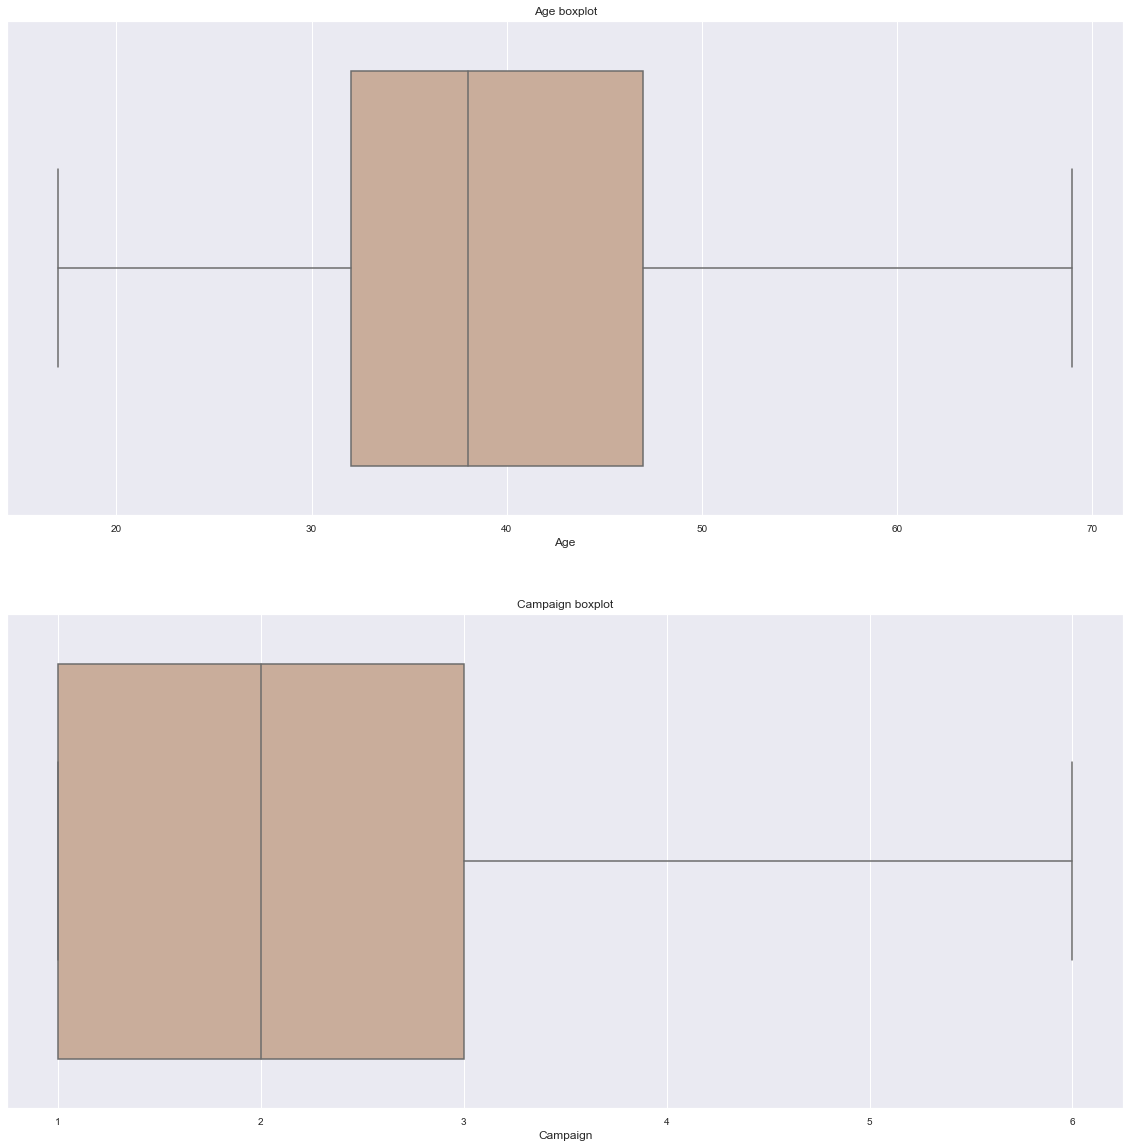

In [17]:
plt.figure(figsize = (20,20))
plt.subplot(2, 1, 1)
sns.boxplot(data = bank_df_iqr, x= 'age', palette = 'pink')
plt.title('Age boxplot')
plt.xlabel('Age')

plt.subplot(2, 1, 2)
sns.boxplot(data = bank_df_iqr, x= 'campaign', palette = 'pink')
plt.title('Campaign boxplot')
plt.xlabel('Campaign')

In [18]:
bank_df_iqr.shape

(38327, 21)

In [19]:
bank_df=bank_df_iqr.copy()

In [20]:
bank_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_range
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,No previous contacted
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,No previous contacted
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,No previous contacted
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,No previous contacted
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,No previous contacted
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38322,37,admin.,married,university.degree,no,yes,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes,No previous contacted
38323,29,unemployed,single,basic.4y,no,yes,no,cellular,nov,fri,1,9,1,success,-1.1,94.767,-50.8,1.028,4963.6,no,6-10
38324,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,No previous contacted
38325,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no,No previous contacted


### 2) WOE

In [60]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [61]:
#Binarization of target 

bank_df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [62]:
aux = bank_df['y'] == 'no'
aux1 = bank_df['y'] == 'yes'

#CONVIERTO
bank_df.at[aux, 'y'] = 0
bank_df.at[aux1, 'y'] = 1

bank_df['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [63]:
iv, woe = iv_woe(data = bank_df, target = 'y', bins=10, show_woe = True)


Information value of age is 0.139397
  Variable          Cutoff     N  Events  % of Events  Non-Events  \
0      age  (16.999, 28.0]  4216     736     0.158621        3480   
1      age    (28.0, 31.0]  5114     608     0.131034        4506   
2      age    (31.0, 33.0]  3679     394     0.084914        3285   
3      age    (33.0, 35.0]  3504     351     0.075647        3153   
4      age    (35.0, 38.0]  4662     434     0.093534        4228   
5      age    (38.0, 41.0]  3871     311     0.067026        3560   
6      age    (41.0, 45.0]  4311     348     0.075000        3963   
7      age    (45.0, 49.0]  3776     289     0.062284        3487   
8      age    (49.0, 55.0]  4473     428     0.092241        4045   
9      age    (55.0, 98.0]  3582     741     0.159698        2841   

   % of Non-Events       WoE        IV  
0         0.095217  0.510355  0.032358  
1         0.123290  0.060922  0.000472  
2         0.089882 -0.056859  0.000282  
3         0.086270 -0.131411  0.001396 

Information value of poutcome is 0.547671
   Variable       Cutoff      N  Events  % of Events  Non-Events  \
0  poutcome      failure   4252     605     0.130388        3647   
1  poutcome  nonexistent  35563    3141     0.676940       32422   
2  poutcome      success   1373     894     0.192672         479   

   % of Non-Events       WoE        IV  
0         0.099787  0.267480  0.008185  
1         0.887107 -0.270384  0.056826  
2         0.013106  2.687917  0.482660  
Information value of emp.var.rate is 1.06975
       Variable  Cutoff      N  Events  % of Events  Non-Events  \
0  emp.var.rate    -3.4   1071     454     0.097845         617   
1  emp.var.rate    -3.0    172      88     0.018966          84   
2  emp.var.rate    -2.9   1663     594     0.128017        1069   
3  emp.var.rate    -1.8   9184    1461     0.314871        7723   
4  emp.var.rate    -1.7    773     403     0.086853         370   
5  emp.var.rate    -1.1    635     301     0.064871         334   
6  emp.

In [64]:
print(iv)


         Variable        IV
0             age  0.139397
0             job  0.188713
0         marital  0.028215
0       education  0.048576
0         default  0.127776
0         housing  0.001383
0            loan  0.000269
0         contact  0.251663
0           month  0.485117
0     day_of_week  0.006493
0        campaign  0.054246
0           pdays  0.000000
0        previous  0.350500
0        poutcome  0.547671
0    emp.var.rate  1.069750
0  cons.price.idx  0.440236
0   cons.conf.idx  0.860740
0       euribor3m  1.046047
0     nr.employed  1.173723


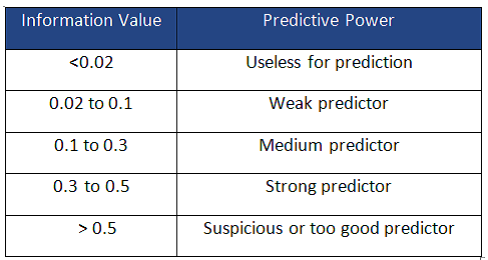

According to previous table:

- Useless for prediction: ["housing", "loan", "day_of_week", "pdays"]
- Weak predictor: ["marital", "education", "campaign"]
- Medium predictor: ["age", "job", "contact","default"]
- Strong predictor: ["month", "previous", "cons.price.idx"]
- Suspicious or too good predictor: ["nr.employed", "euribor3m", "cons.conf.idx", "emp.var.rate", "poutcome", "pdays_range" (created feature)]

### Replacement with WOE values

As we said before, we will treat "age" and "campaign".

In [65]:
#Creation of dataframe for WOE

bank_df_woe= bank_df.copy()

In [66]:
# AGE
#CREATE A DATAFRAME
age= pd.DataFrame(bank_df_woe['age'])
age.columns = ['age']
age, age.columns

(       age
 0       56
 1       57
 2       37
 3       40
 4       56
 ...    ...
 41183   73
 41184   46
 41185   56
 41186   44
 41187   74
 
 [41188 rows x 1 columns],
 Index(['age'], dtype='object'))

In [67]:
age_table = woe[:10]
age_table

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,age,"(16.999, 28.0]",4216,736,0.158621,3480,0.095217,0.510355,0.032358
1,age,"(28.0, 31.0]",5114,608,0.131034,4506,0.123290,0.060922,0.000472
2,age,"(31.0, 33.0]",3679,394,0.084914,3285,0.089882,-0.056859,0.000282
3,age,"(33.0, 35.0]",3504,351,0.075647,3153,0.086270,-0.131411,0.001396
4,age,"(35.0, 38.0]",4662,434,0.093534,4228,0.115683,-0.212528,0.004707
5,age,"(38.0, 41.0]",3871,311,0.067026,3560,0.097406,-0.373811,0.011356
6,age,"(41.0, 45.0]",4311,348,0.075000,3963,0.108433,-0.368642,0.012325
7,age,"(45.0, 49.0]",3776,289,0.062284,3487,0.095409,-0.426458,0.014126
8,age,"(49.0, 55.0]",4473,428,0.092241,4045,0.110676,-0.182202,0.003359
9,age,"(55.0, 98.0]",3582,741,0.159698,2841,0.077733,0.720001,0.059015


In [68]:
#CREATE STRUCTURE TO EXTRACT LIMITS
idx = pd.IntervalIndex(age_table['Cutoff'])

#INTERVALS , LIMITS AND WOE VALUES
inter = pd.DataFrame({'intervals': idx, 'left': idx.left, 'right': idx.right})
inter['WOE'] = age_table['WoE']
inter

,intervals,left,right,WOE
0,"(16.999, 28.0]",16.999,28.0,0.510355
1,"(28.0, 31.0]",28.000,31.0,0.060922
2,"(31.0, 33.0]",31.000,33.0,-0.056859
3,"(33.0, 35.0]",33.000,35.0,-0.131411
4,"(35.0, 38.0]",35.000,38.0,-0.212528
5,"(38.0, 41.0]",38.000,41.0,-0.373811
6,"(41.0, 45.0]",41.000,45.0,-0.368642
7,"(45.0, 49.0]",45.000,49.0,-0.426458
8,"(49.0, 55.0]",49.000,55.0,-0.182202
9,"(55.0, 98.0]",55.000,98.0,0.720001


In [69]:
#CREATE AUXILIARY VARIABLES
inter['left'][0],inter['right'][0]

aux1 = (inter['left'][0] <=  age) & (age < inter['right'][0])
aux2 = (inter['left'][1] <=  age) & (age < inter['right'][1])
aux3 = (inter['left'][2] <=  age) & (age < inter['right'][2])
aux4 = (inter['left'][3] <=  age) & (age < inter['right'][3])
aux5 = (inter['left'][4] <=  age) & (age < inter['right'][4])
aux6 = (inter['left'][5] <=  age) & (age < inter['right'][5])
aux7 = (inter['left'][6] <=  age) & (age < inter['right'][6])
aux8 = (inter['left'][7] <=  age) & (age < inter['right'][7])
aux9 = (inter['left'][8] <=  age) & (age < inter['right'][8])
aux10 = (inter['left'][9] <=  age) & (age <= inter['right'][9])

In [70]:
#REPLACE VALUES WITH WOE
age[aux1] = inter['WOE'][0]
age[aux2] = inter['WOE'][1]
age[aux3] = inter['WOE'][2]
age[aux4] = inter['WOE'][3]
age[aux5] = inter['WOE'][4]
age[aux6] = inter['WOE'][5]
age[aux7] = inter['WOE'][6]
age[aux8] = inter['WOE'][7]
age[aux9] = inter['WOE'][8]
age[aux10] = inter['WOE'][9]

age.value_counts()

age      
-0.212528    5014
-0.182202    4664
-0.368642    4486
 0.720001    4230
 0.060922    4168
-0.426458    4040
-0.373811    4000
-0.056859    3793
-0.131411    3578
 0.510355    3215
dtype: int64

In [71]:
#REPLACE OLD VARIABLE
bank_df_woe['age'] = age
bank_df_woe['age'].value_counts()

-0.212528    5014
-0.182202    4664
-0.368642    4486
 0.720001    4230
 0.060922    4168
-0.426458    4040
-0.373811    4000
-0.056859    3793
-0.131411    3578
 0.510355    3215
Name: age, dtype: int64

In [72]:
#CAMPAIGN
#CREATE A DATAFRAME
campaign= pd.DataFrame(bank_df_woe['campaign'])
campaign.columns = ['campaign']
campaign['campaign'].value_counts()



1     17642
2     10570
3      5341
4      2651
5      1599
6       979
7       629
8       400
9       283
10      225
11      177
12      125
13       92
14       69
17       58
15       51
16       51
18       33
20       30
19       26
21       24
22       17
23       16
24       15
27       11
29       10
25        8
26        8
28        8
30        7
31        7
35        5
33        4
32        4
34        3
40        2
42        2
43        2
37        1
39        1
41        1
56        1
Name: campaign, dtype: int64

In [73]:
#SELECT VALUES FOR CAMPAIGN VARIABLE
aux_c = woe['Variable'] == 'campaign' 
campaign_table = woe[aux_c]
campaign_table

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,campaign,"(0.999, 2.0]",28212,3511,0.756681,24701,0.675851,0.112969,0.009131
1,campaign,"(2.0, 3.0]",5341,574,0.123707,4767,0.130431,-0.052931,0.000356
2,campaign,"(3.0, 5.0]",4250,369,0.079526,3881,0.106189,-0.289139,0.007709
3,campaign,"(5.0, 56.0]",3385,186,0.040086,3199,0.087529,-0.780935,0.037050


In [74]:
#CREATE STRUCTURE TO EXTRACT LIMITS
idx = pd.IntervalIndex(campaign_table['Cutoff'])

#INTERVALS , LIMITS AND WOE VALUES
inter = pd.DataFrame({'intervals': idx, 'left': idx.left, 'right': idx.right})
inter['WOE'] = campaign_table['WoE']
inter

,intervals,left,right,WOE
0,"(0.999, 2.0]",0.999,2.0,0.112969
1,"(2.0, 3.0]",2.000,3.0,-0.052931
2,"(3.0, 5.0]",3.000,5.0,-0.289139
3,"(5.0, 56.0]",5.000,56.0,-0.780935


In [75]:
#CREATE AUXILIARY VARIABLES
inter['left'][0],inter['right'][0]

aux1 = (inter['left'][0] <=  campaign) & (campaign < inter['right'][0])
aux2 = (inter['left'][1] <=  campaign) & (campaign < inter['right'][1])
aux3 = (inter['left'][2] <=  campaign) & (campaign < inter['right'][2])
aux4 = (inter['left'][3] <=  campaign) & (campaign <= inter['right'][3])

In [76]:
#REPLACE VALUES WITH WOE
campaign[aux1] = inter['WOE'][0]
campaign[aux2] = inter['WOE'][1]
campaign[aux3] = inter['WOE'][2]
campaign[aux4] = inter['WOE'][3]

campaign.value_counts()

campaign 
 0.112969    17642
-0.052931    10570
-0.289139     7992
-0.780935     4984
dtype: int64

In [77]:
#REPLACE OLD VARIABLE
bank_df_woe['campaign'] = campaign
bank_df_woe['campaign'].value_counts()

 0.112969    17642
-0.052931    10570
-0.289139     7992
-0.780935     4984
Name: campaign, dtype: int64

In [78]:
bank_df_woe.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.720001,housemaid,married,basic.4y,no,no,no,telephone,may,mon,0.112969,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,0.720001,services,married,high.school,unknown,no,no,telephone,may,mon,0.112969,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,-0.212528,services,married,high.school,no,yes,no,telephone,may,mon,0.112969,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [79]:
bank_df_woe.shape

(41188, 20)

From here, we continue with bank_df_woe as our dataframe for modeling.

In [80]:
bank_df = bank_df_woe.copy()

Text(0.5, 0, 'Campaign')

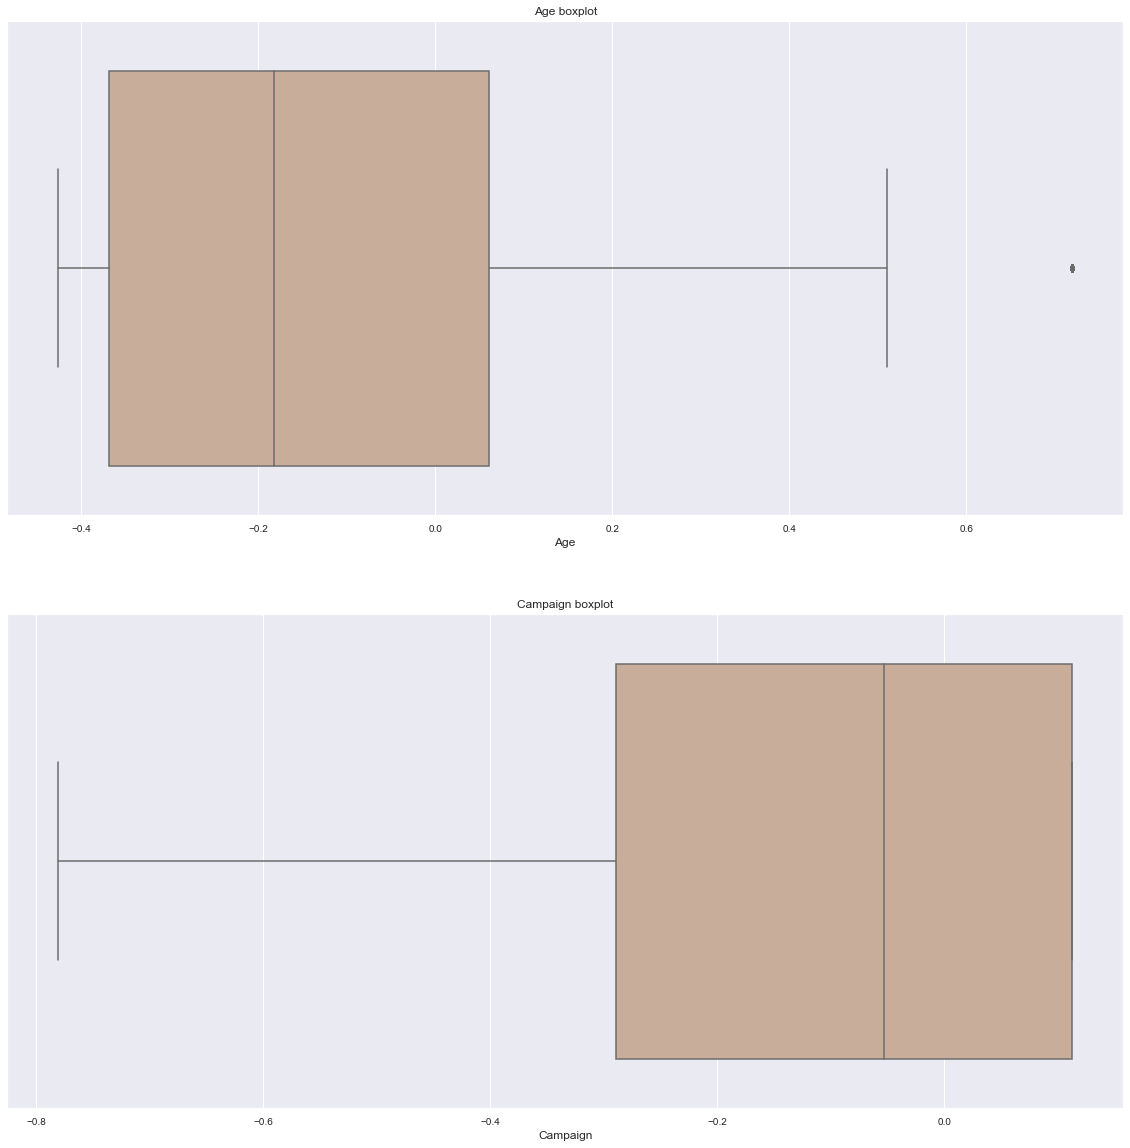

In [81]:
plt.figure(figsize = (20,20))
plt.subplot(2, 1, 1)
sns.boxplot(data = bank_df, x= 'age', palette = 'pink')
plt.title('Age boxplot')
plt.xlabel('Age')

plt.subplot(2, 1, 2)
sns.boxplot(data = bank_df, x= 'campaign', palette = 'pink')
plt.title('Campaign boxplot')
plt.xlabel('Campaign')

## 2) Skew

In [82]:
bank_df.skew()

age               1.149065
campaign         -1.319181
pdays            -4.922190
previous          3.832042
emp.var.rate     -0.724096
cons.price.idx   -0.230888
cons.conf.idx     0.303180
euribor3m        -0.709188
nr.employed      -1.044262
y                 2.450330
dtype: float64

In [83]:
bank_df['pdays'] = np.sqrt(bank_df['pdays'])
bank_df['previous'] = np.sqrt(bank_df['previous'])

In [84]:
bank_df.skew()

age               1.149065
campaign         -1.319181
pdays            -4.927351
previous          2.388752
emp.var.rate     -0.724096
cons.price.idx   -0.230888
cons.conf.idx     0.303180
euribor3m        -0.709188
nr.employed      -1.044262
y                 2.450330
dtype: float64

In [85]:
bank_df=bank_df_woe.copy()

In [76]:
bank_df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
pdays_range       0
dtype: int64

Due to the values of the variable pdays the sqrt function have no effect in it.

## 3) Missing values

We are aware that the dataset has missing values under the string "unknown". At first, we will replace the string with np.NaN, then we are going to do nothing, keeping "unknown" as an own category, to avoid the lost of valuable information through droping Nan and deleting them.

In [48]:
bank_df= bank_df.replace(to_replace="unknown" ,value=np.NaN,regex=True)

In [49]:
print(bank_df.isnull().sum())

null_columns=["job","marital","education","default","housing","loan"]

age                  0
job                298
marital             70
education         1576
default           7949
housing            920
loan               920
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
pdays_range          0
dtype: int64


In [50]:
nulls=bank_df[null_columns].isnull().sum()
print("Q of nulls: ")
print(nulls)

print("% of nulls: ")
print(nulls/bank_df.shape[0]*100)

Q of nulls: 
job           298
marital        70
education    1576
default      7949
housing       920
loan          920
dtype: int64
% of nulls: 
job           0.777520
marital       0.182639
education     4.111984
default      20.739948
housing       2.400397
loan          2.400397
dtype: float64


Text(0.5, 0, 'Features')

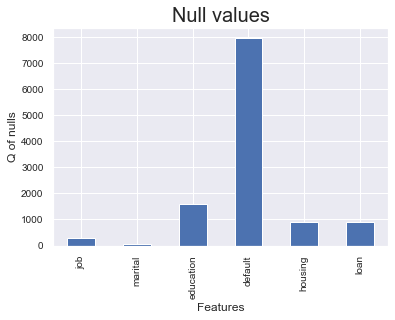

In [51]:


nulls.plot.bar()

plt.title('Null values', fontsize=20)
plt.ylabel('Q of nulls')
plt.xlabel('Features')

In order ot be more sure what is the best option of missing values treatment for the model, we are going to analyse a little bit deeper the features with null values.

First "default", the feature with most nulls. It has 20.9% of missing values.

In [52]:
print("Value Distribution: ")
print(bank_df.default.value_counts())

print("Value Distribution %: ")
print(bank_df.default.value_counts()/bank_df.default.notnull().sum()*100)

Value Distribution: 
no     30375
yes        3
Name: default, dtype: int64
Value Distribution %: 
no     99.990124
yes     0.009876
Name: default, dtype: float64


In one hand, the feature "default" has a considerable quantity of nulls (20.9%), so the imputation is risky for the model. It could generate a big bias. The goal is to make a model as realistic and useful as possible, so imputation would not be a good option in this feature.

In the other hand, it is highly umbalanced. Considering not null values, just 0.009% of clients are in default.

Additionally, according to IV, default has a 0.128 value, that means that is a medium predictor. 

All these evidence, lead us to think that the best option is to delete its null values. Despite this, we are going to analyse the model with the deletion of Nan, imputation through KNNImputer (for loan, housing and default) and keeping "unknown" as a category.



### 1) KNNImputer 

In [53]:
knn_bank_df=bank_df.copy()

In [48]:
knn_bank_df.isnull().sum()

age                  0
job                330
marital             80
education         1731
default           8597
housing            990
loan               990
contact              0
month                0
day_of_week          0
campaign             0
pdays                0
previous             0
poutcome             0
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
pdays_range          0
dtype: int64

In [49]:
aux = knn_bank_df['default'] == 'no'
aux1 = knn_bank_df['default'] == 'yes'

#CONVIERTO
knn_bank_df.at[aux, 'default'] = 0
knn_bank_df.at[aux1, 'default'] = 1

aux = knn_bank_df['housing'] == 'no'
aux1 = knn_bank_df['housing'] == 'yes'

#CONVIERTO
knn_bank_df.at[aux, 'housing'] = 0
knn_bank_df.at[aux1, 'housing'] = 1

aux = knn_bank_df['loan'] == 'no'
aux1 = knn_bank_df['loan'] == 'yes'

#CONVIERTO
knn_bank_df.at[aux, 'loan'] = 0
knn_bank_df.at[aux1, 'loan'] = 1

In [50]:
%%time
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2,weights='uniform',metric='nan_euclidean')
x= knn_bank_df[["default","housing","loan"]]
x=imputer.fit_transform(x)
knn_bank_df.loc[:,["default","housing","loan"]]= x

CPU times: user 15.5 s, sys: 19.4 s, total: 34.9 s
Wall time: 15.6 s


In [51]:
#Binarization of the imputation done by KNN

knn_bank_df["loan"]=knn_bank_df.loan.astype(bool).astype(float)
knn_bank_df["housing"]=knn_bank_df.housing.astype(bool).astype(float)
knn_bank_df["default"]=knn_bank_df.default.astype(bool).astype(float)

In [52]:
knn_bank_df.isnull().mean()*100

age               0.000000
job               0.801204
marital           0.194231
education         4.202680
default           0.000000
housing           0.000000
loan              0.000000
contact           0.000000
month             0.000000
day_of_week       0.000000
campaign          0.000000
pdays             0.000000
previous          0.000000
poutcome          0.000000
emp.var.rate      0.000000
cons.price.idx    0.000000
cons.conf.idx     0.000000
euribor3m         0.000000
nr.employed       0.000000
y                 0.000000
pdays_range       0.000000
dtype: float64

For the rest of features with null values, it does not make sense to do any imputation because the null values are few.

In [53]:
knn_bank_df.dropna(subset=["job", "marital", "education"],axis=0,inplace=True)

In [54]:
knn_bank_df.shape

(39191, 21)

### 2) Drop all null values 

In [55]:
bank_df_dropna=bank_df.copy()

In [56]:
bank_df_dropna= bank_df_dropna.replace(to_replace="unknown" ,value=np.NaN,regex=True)

In [57]:
bank_df_dropna.dropna(axis=0,inplace=True)

In [58]:
bank_df_dropna.isnull().mean()

age               0.0
job               0.0
marital           0.0
education         0.0
default           0.0
housing           0.0
loan              0.0
contact           0.0
month             0.0
day_of_week       0.0
campaign          0.0
pdays             0.0
previous          0.0
poutcome          0.0
emp.var.rate      0.0
cons.price.idx    0.0
cons.conf.idx     0.0
euribor3m         0.0
nr.employed       0.0
y                 0.0
pdays_range       0.0
dtype: float64

In [59]:
bank_df_dropna.shape

(30488, 21)

In [60]:
sorted_bank_df = bank_df.sort_values("default")

Grouping and relation visualization:

<AxesSubplot:>

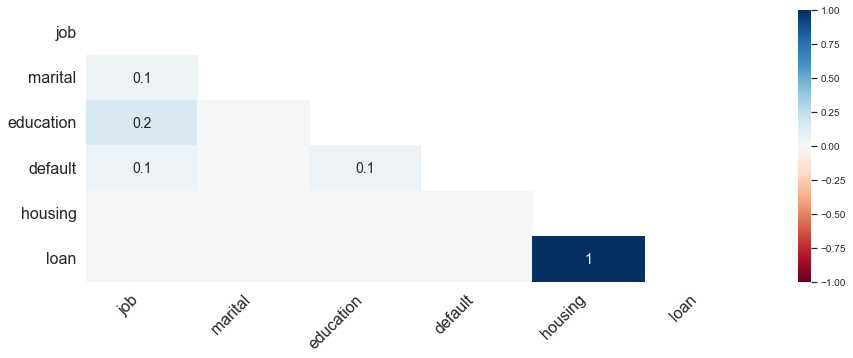

In [61]:
msno.heatmap(sorted_bank_df, figsize=(15,5))

<AxesSubplot:>

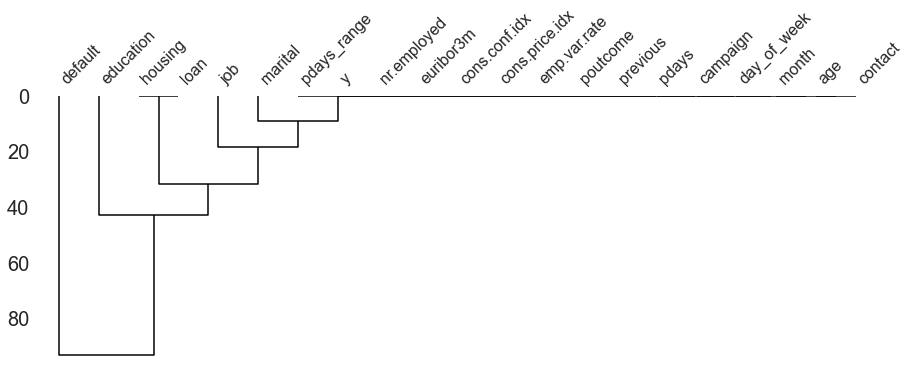

In [62]:
msno.dendrogram(sorted_bank_df, figsize=(15,5))

### 3) "Unknown" as a category

In [43]:
bank_df.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_range
0,0.720001,housemaid,married,basic.4y,no,no,no,telephone,may,mon,0.112969,31.606961,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,No previous contacted
1,0.720001,services,married,high.school,unknown,no,no,telephone,may,mon,0.112969,31.606961,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,No previous contacted
2,-0.212528,services,married,high.school,no,yes,no,telephone,may,mon,0.112969,31.606961,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,No previous contacted


## 4) Modeling

In [86]:
aux = bank_df['y'] == 'no'
aux1 = bank_df['y'] == 'yes'

#CONVIERTO
bank_df.at[aux, 'y'] = 0
bank_df.at[aux1, 'y'] = 1

bank_df['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64

In [87]:
bank_df["y"]=bank_df.y.astype(int)

In [79]:
bank_df.dtypes

age                float64
job                 object
marital             object
education           object
default             object
housing             object
loan                object
contact             object
month               object
day_of_week         object
campaign           float64
pdays                int64
previous             int64
poutcome            object
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
y                    int64
pdays_range       category
dtype: object

In [80]:
bank_df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
pdays_range       0
dtype: int64

In [96]:
numerical_cols = bank_df.select_dtypes(include=[np.number]).columns.to_list()
numerical_cols.remove("y")
numerical_cols

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [90]:
categorical_cols = bank_df.select_dtypes(include=["object","category"]).columns.to_list()
#categorical_cols.remove("pdays_range")
categorical_cols

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

### Chosen dataset:  "Unknown" as a category

In [97]:
bank_df.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.720001,housemaid,married,basic.4y,no,no,no,telephone,may,mon,0.112969,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,0.720001,services,married,high.school,unknown,no,no,telephone,may,mon,0.112969,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [98]:
clfs = setup(data = bank_df, target = 'y',
             session_id=234, normalize=True, 
             numeric_features=numerical_cols, categorical_features=categorical_cols, 
             transformation = True, 
             remove_multicollinearity = True, multicollinearity_threshold = 0.95, 
             fix_imbalance=True,
             data_split_stratify=True)

,Description,Value
0,session_id,234
1,Target,y
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(41188, 20)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,10
8,Ordinal Features,False
9,High Cardinality Features,False


In [99]:
models = compare_models(sort="AUC", n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8960,0.8001,0.3245,0.5671,0.4126,0.3602,0.3772,0.5950
catboost,CatBoost Classifier,0.8976,0.7950,0.3104,0.5866,0.4057,0.3555,0.3772,5.6170
lr,Logistic Regression,0.8239,0.7908,0.6367,0.3468,0.4489,0.3548,0.3781,0.5920
lda,Linear Discriminant Analysis,0.8197,0.7902,0.6379,0.3402,0.4436,0.3477,0.3724,0.2720
gbc,Gradient Boosting Classifier,0.8851,0.7878,0.4788,0.4900,0.4842,0.4195,0.4196,1.9140
rf,Random Forest Classifier,0.8865,0.7777,0.3513,0.4959,0.4108,0.3501,0.3567,1.2280
ada,Ada Boost Classifier,0.8691,0.7713,0.5243,0.4332,0.4743,0.4003,0.4028,0.5090
et,Extra Trees Classifier,0.8806,0.7554,0.3455,0.4607,0.3945,0.3298,0.3342,1.3420
nb,Naive Bayes,0.7568,0.7474,0.6364,0.2670,0.3737,0.2550,0.2927,0.1000
knn,K Neighbors Classifier,0.7397,0.7259,0.6179,0.2427,0.3485,0.2228,0.2608,2.5870


Our chosen model is LGBMClassifier. We are also trying the second and the third: CatBoost Classifier and Logistic Regression. 

In [100]:
lgbm = create_model("lightgbm")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8970,0.7742,0.3108,0.5805,0.4048,0.3540,0.3748
1,0.9008,0.8085,0.3673,0.5950,0.4542,0.4030,0.4172
2,0.8932,0.8076,0.3117,0.5430,0.3961,0.3422,0.3581
3,0.8994,0.8032,0.3231,0.6000,0.4200,0.3703,0.3917
4,0.8942,0.8063,0.3138,0.5543,0.4008,0.3476,0.3646
5,0.8914,0.7966,0.3077,0.5319,0.3899,0.3349,0.3501
6,0.8949,0.8243,0.3262,0.5579,0.4117,0.3583,0.3739
7,0.9011,0.7982,0.3508,0.6064,0.4444,0.3944,0.4123
8,0.8935,0.7854,0.3015,0.5506,0.3897,0.3367,0.3551
9,0.8942,0.7972,0.3323,0.5510,0.4146,0.3603,0.3743


In [240]:
print(lgbm)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=234, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [101]:
tuned_lgbm = tune_model(lgbm, optimize="AUC")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8991,0.7743,0.3046,0.6037,0.4049,0.3562,0.3812
1,0.9032,0.8102,0.3395,0.6286,0.4409,0.3930,0.4155
2,0.8939,0.8054,0.2901,0.5529,0.3806,0.3286,0.3492
3,0.9039,0.8137,0.3200,0.6500,0.4289,0.3830,0.4118
4,0.8984,0.8103,0.3231,0.5899,0.4175,0.3670,0.3870
5,0.8970,0.8042,0.2862,0.5886,0.3851,0.3361,0.3623
6,0.8994,0.8210,0.3231,0.6000,0.4200,0.3703,0.3917
7,0.8991,0.7935,0.3077,0.6024,0.4073,0.3584,0.3827
8,0.8959,0.7878,0.2800,0.5796,0.3776,0.3283,0.3543
9,0.8928,0.7919,0.3138,0.5426,0.3977,0.3434,0.3590


In [102]:
import joblib

In [103]:
joblib.dump(tuned_lgbm, 'model.pkl')

['model.pkl']

In [104]:
print(tuned_lgbm)

LGBMClassifier(bagging_fraction=0.5, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.239, max_depth=-1,
               min_child_samples=40, min_child_weight=0.001, min_split_gain=0.1,
               n_estimators=270, n_jobs=-1, num_leaves=10, objective=None,
               random_state=234, reg_alpha=10, reg_lambda=5, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


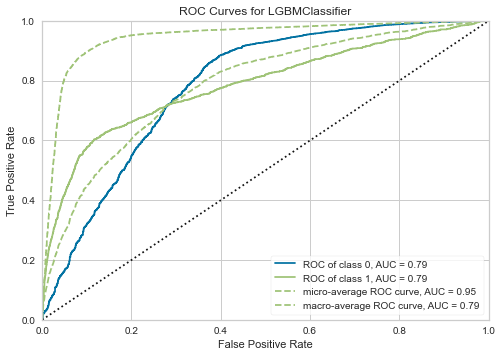

In [89]:
plot_model(tuned_lgbm, plot = 'auc')

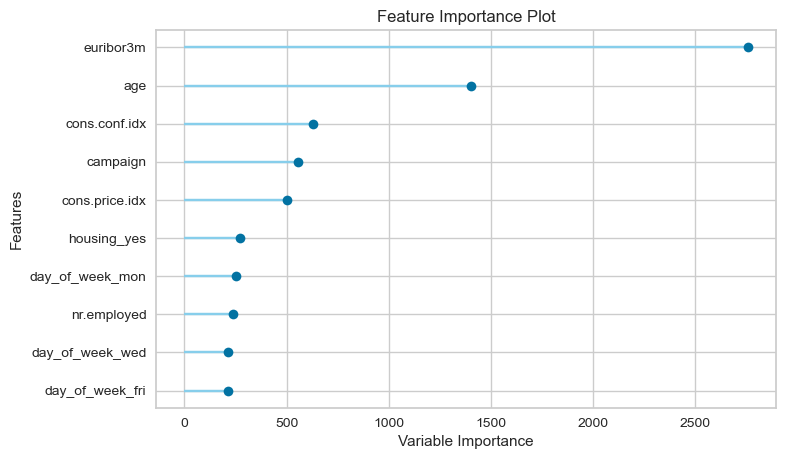

In [243]:
plot_model(tuned_lgbm, plot='feature')


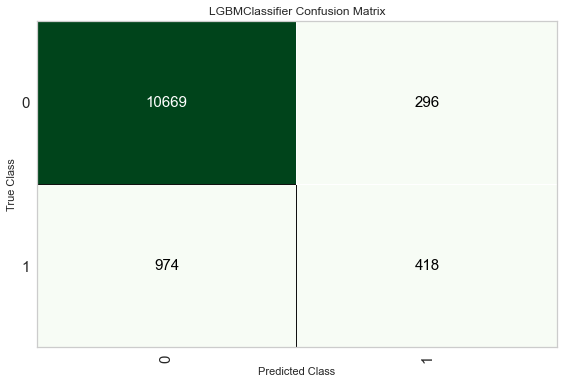

In [244]:
plot_model(tuned_lgbm, plot = 'confusion_matrix')


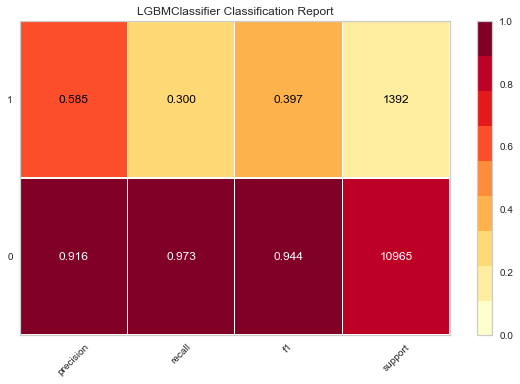

In [245]:
plot_model(tuned_lgbm, plot = 'class_report')

## *Chosen Model LGBMClassifier*

## Light Gradient Boosting Machine Classifier



According to pycaret, this is the best model (based on AUC).

In [173]:
import lightgbm as lgb
import pickle
import joblib


In [174]:
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [175]:
bank_df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0.720001,housemaid,married,basic.4y,no,no,no,telephone,may,mon,0.112969,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,0.720001,services,married,high.school,unknown,no,no,telephone,may,mon,0.112969,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,-0.212528,services,married,high.school,no,yes,no,telephone,may,mon,0.112969,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,-0.373811,admin.,married,basic.6y,no,no,no,telephone,may,mon,0.112969,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,0.720001,services,married,high.school,no,no,yes,telephone,may,mon,0.112969,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.720001,retired,married,professional.course,no,yes,no,cellular,nov,fri,0.112969,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41184,-0.426458,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,0.112969,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41185,0.720001,retired,married,university.degree,no,yes,no,cellular,nov,fri,-0.052931,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41186,-0.368642,technician,married,professional.course,no,no,no,cellular,nov,fri,0.112969,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1


In [176]:
X = bank_df.drop("y",axis=1)

y = bank_df.y

In [177]:
bank_df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [194]:
params={'n_estimators': [350, 400, 450],
 'max_depth': [7, 9, 11],
 'learning_rate': [0.01,0.03,0.08]}

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 127)

In [180]:
enc=OneHotEncoder(drop="first")

X_train_OH = pd.DataFrame(enc.fit_transform(X_train[categorical_cols]).toarray())

X_test_OH= pd.DataFrame(enc.transform(X_test[categorical_cols]).toarray())

In [181]:
joblib.dump(enc, 'encoder.pkl')

['encoder.pkl']

In [182]:
X_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
9364,-0.368642,blue-collar,married,basic.9y,unknown,no,no,telephone,jun,fri,-0.780935,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1
10912,0.060922,services,single,high.school,no,no,no,telephone,jun,wed,0.112969,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1
13381,0.510355,blue-collar,single,basic.9y,no,yes,no,cellular,jul,wed,0.112969,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
9451,-0.373811,management,married,university.degree,no,yes,no,telephone,jun,fri,0.112969,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1
22439,-0.373811,housemaid,married,professional.course,no,no,no,cellular,aug,fri,0.112969,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39837,0.060922,admin.,single,university.degree,no,no,no,cellular,jun,wed,-0.052931,3,4,success,-1.7,94.055,-39.8,0.715,4991.6
27684,-0.426458,admin.,married,high.school,no,yes,yes,telephone,dec,fri,0.112969,999,0,nonexistent,-0.2,92.756,-45.9,3.563,5176.3
17500,-0.212528,admin.,married,university.degree,no,no,no,cellular,jul,mon,-0.289139,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
866,-0.212528,technician,married,professional.course,no,yes,no,telephone,may,wed,0.112969,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0


In [183]:
X_train_OH

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
30888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
30889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [184]:
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])

X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [185]:
X_train

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
9364,-0.861582,blue-collar,married,basic.9y,unknown,no,no,telephone,jun,fri,-2.293871,0.195213,-0.348048,nonexistent,0.836015,1.540006,-0.282335,0.773437,0.843071
10912,0.344326,services,single,high.school,no,no,no,telephone,jun,wed,0.795194,0.195213,-0.348048,nonexistent,0.836015,1.540006,-0.282335,0.770552,0.843071
13381,1.606012,blue-collar,single,basic.9y,no,yes,no,cellular,jul,wed,0.795194,0.195213,-0.348048,nonexistent,0.836015,0.593513,-0.477150,0.770552,0.843071
9451,-0.876092,management,married,university.degree,no,yes,no,telephone,jun,fri,0.795194,0.195213,-0.348048,nonexistent,0.836015,1.540006,-0.282335,0.773437,0.843071
22439,-0.876092,housemaid,married,professional.course,no,no,no,cellular,aug,fri,0.795194,0.195213,-0.348048,nonexistent,0.836015,-0.226665,0.951496,0.771706,0.843071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39837,0.344326,admin.,single,university.degree,no,no,no,cellular,jun,wed,0.221892,-5.138495,7.783205,success,-1.137402,0.830569,0.150588,-1.680373,-2.438408
27684,-1.023889,admin.,married,high.school,no,yes,yes,telephone,dec,fri,0.795194,0.195213,-0.348048,nonexistent,-0.182523,-1.417136,-1.169827,-0.036805,0.124337
17500,-0.423325,admin.,married,university.degree,no,no,no,cellular,jul,mon,-0.594373,0.195213,-0.348048,nonexistent,0.836015,0.593513,-0.477150,0.770552,0.843071
866,-0.423325,technician,married,professional.course,no,yes,no,telephone,may,wed,0.795194,0.195213,-0.348048,nonexistent,0.645039,0.725019,0.886557,0.709380,0.328302


In [186]:


joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [187]:
X_train.drop(categorical_cols,axis=1,inplace=True)

X_test.drop(categorical_cols,axis=1,inplace=True)

In [188]:
X_train=X_train.join(X_train_OH)
X_test=X_test.join(X_test_OH)

In [193]:
X_train

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
9364,-0.861582,-2.293871,0.195213,-0.348048,0.836015,1.540006,-0.282335,0.773437,0.843071,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10912,0.344326,0.795194,0.195213,-0.348048,0.836015,1.540006,-0.282335,0.770552,0.843071,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13381,1.606012,0.795194,0.195213,-0.348048,0.836015,0.593513,-0.477150,0.770552,0.843071,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9451,-0.876092,0.795194,0.195213,-0.348048,0.836015,1.540006,-0.282335,0.773437,0.843071,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
22439,-0.876092,0.795194,0.195213,-0.348048,0.836015,-0.226665,0.951496,0.771706,0.843071,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39837,0.344326,0.221892,-5.138495,7.783205,-1.137402,0.830569,0.150588,-1.680373,-2.438408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27684,-1.023889,0.795194,0.195213,-0.348048,-0.182523,-1.417136,-1.169827,-0.036805,0.124337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17500,-0.423325,-0.594373,0.195213,-0.348048,0.836015,0.593513,-0.477150,0.770552,0.843071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
866,-0.423325,0.795194,0.195213,-0.348048,0.645039,0.725019,0.886557,0.709380,0.328302,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [189]:
mdl = lgb.LGBMClassifier()

In [190]:
grid_lgb = GridSearchCV(mdl, param_grid=params,cv=5, verbose=1, n_jobs=-1,scoring="roc_auc")

In [195]:
grid_lgb.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  1.2min finished


GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.08],
                         'max_depth': [9, 11, 13],
                         'n_estimators': [350, 400, 450]},
             scoring='roc_auc', verbose=1)

In [196]:
grid_lgb.best_params_

{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 350}

In [197]:
best_model=grid_lgb.best_estimator_
best_model.fit(X_train,y_train)

LGBMClassifier(learning_rate=0.01, max_depth=9, n_estimators=350)

In [200]:
from sklearn.utils.validation import check_is_fitted

In [ ]:
"classes_"

In [201]:
check_is_fitted(best_model,"classes_")

In [211]:
best_model.fit(X_train,y_train)

check_is_fitted(best_model,"estimator_")

NotFittedError: This LGBMClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [202]:

joblib.dump(best_model, 'model.pkl')



['model.pkl']

pickle

In [204]:
loaded_model = joblib.load('model.pkl')
result = loaded_model.score(X_test, y_test)
print(result)

0.8984170146644653


In [198]:
prediction_model=best_model.predict(X_test)

In [199]:
prediction_test=best_model.predict(X_test)
prediction_train=best_model.predict(X_train)

print("Accuracy Test: ",accuracy_score(y_test, prediction_test))
print("Accuracy Train: ",accuracy_score(y_train, prediction_train))

prediction_model_proba = best_model.predict_proba(X_test)
prediction_model_class_1 = prediction_model_proba[:, 1]
auc_model = roc_auc_score(y_test, prediction_model_class_1)
print("AUC TEST: ",auc_model)


prediction_model_proba_train = best_model.predict_proba(X_train)
prediction_model_class_1_train = prediction_model_proba_train[:, 1]
auc_model_train = roc_auc_score(y_train, prediction_model_class_1_train)
print("AUC TRAIN: ",auc_model_train)

Accuracy Test:  0.8984170146644653
Accuracy Train:  0.9038231200025898
AUC TEST:  0.7991791244067545
AUC TRAIN:  0.839510012308935


In [113]:
tn, fp, fn, tp = confusion_matrix(y_test, prediction_model).ravel()
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

True Positives: 326
False Positives: 159
True Negatives: 8949
False Negatives: 863


In [115]:
predict_lgbm = best_model.predict_proba(X_test_scl)
predict_lgbm_class_1 = predict_lgbm[:, 1]
performance_lgbm = roc_auc_score(y_test, predict_lgbm_class_1)
performance_lgbm

0.806620063951764

In [116]:
from sklearn.metrics import roc_curve
fpr_log,tpr_log,thr_log = roc_curve(y_test, predict_lgbm[:,1])

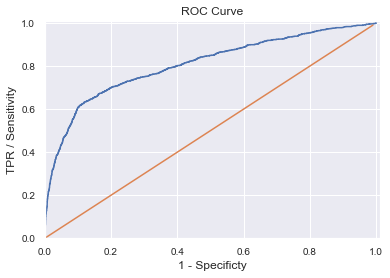

In [117]:
df = pd.DataFrame(dict(fpr=fpr_log, tpr=tpr_log, thr = thr_log))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty'); plt.ylabel('TPR / Sensitivity'); plt.title('ROC Curve')
plt.plot(df['fpr'],df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show()

In [118]:
cm_best_model=pd.DataFrame(confusion_matrix(y_test, prediction_model), 
             columns=['Predicted False', "Predicted True"], index=['Actual False', 'Actual True'])
cm_best_model

,Predicted False,Predicted True
Actual False,8949,159
Actual True,863,326


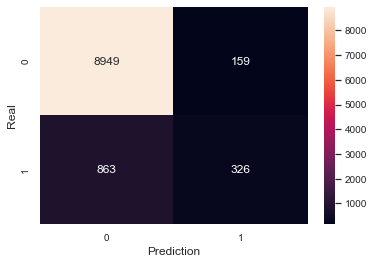

In [119]:
sns.heatmap(confusion_matrix(y_test, prediction_test), annot=True, fmt='.0f')
plt.ylabel('Real')
plt.xlabel('Prediction');

In [291]:
#X.columns.shape
best_model.feature_importances_

array([2116, 1368,  799,  982,  290,  722,  639, 4696,  388], dtype=int32)

In [120]:
feature_imp = pd.DataFrame(sorted(zip(best_model.feature_importances_,X.columns)), columns=['Value','Feature']).sort_values(by="Value",ascending=False)


In [121]:
feature_imp

,Value,Feature
57,2957,euribor3m
56,1237,age
55,989,campaign
54,640,previous
53,612,cons.price.idx
52,504,cons.conf.idx
51,462,pdays
50,455,contact_telephone
49,346,nr.employed
48,330,day_of_week_mon


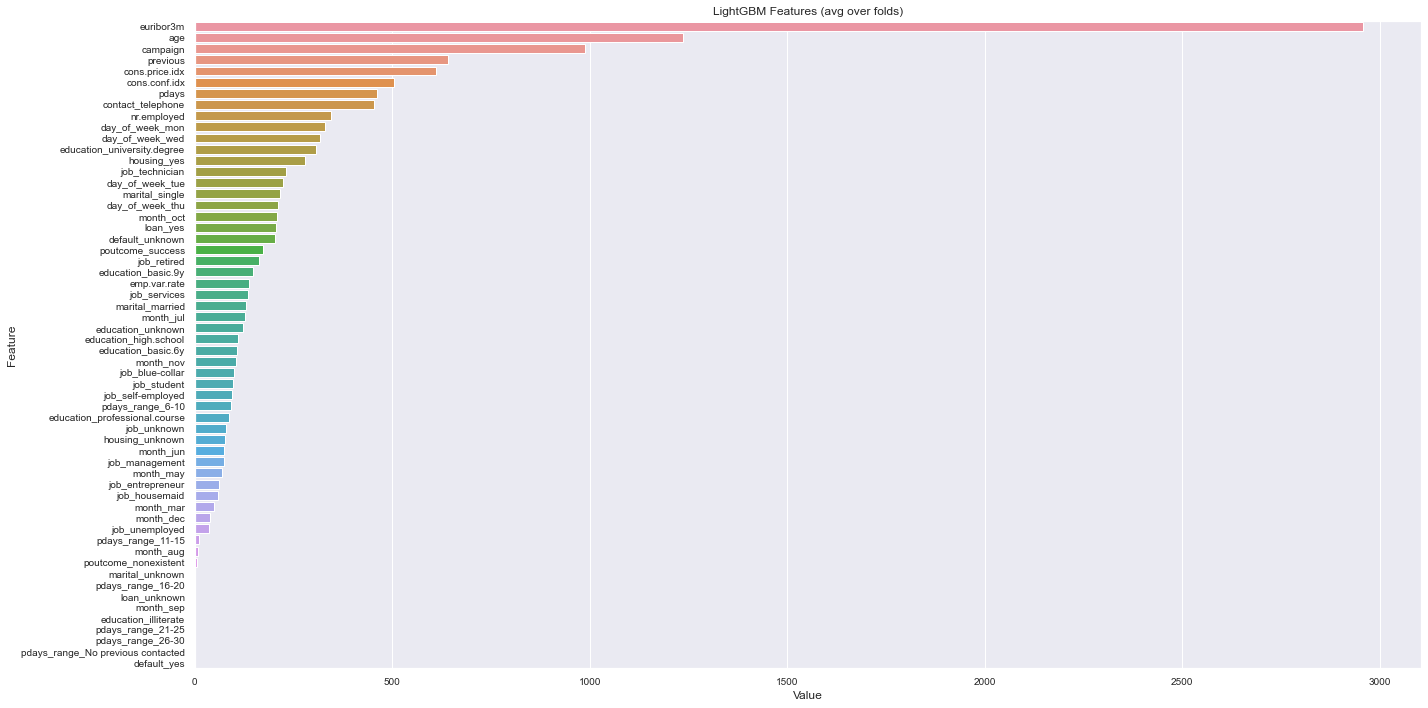

In [122]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')
